# Derin Öğrenme Bootcamp: Brain Tumor Detection Deep Learning


Proje Amacı
Bu projede MRI görüntülerinden **beyin tümörlerini sınıflandırmak** için derin öğrenme yöntemleri kullanılmıştır.  
Amaç:  
- Farklı tümör tiplerini ayırt etmek  
- Custom CNN ve Transfer Learning (MobileNetV2) yöntemlerini karşılaştırmak  
- Açıklanabilirlik yöntemleri (Grad-CAM) ile modelin kararlarını yorumlamak



## Veri Keşfi ve Dataset Yükleme

Brain Tumor MRI Dataset'ini yüklüyor ve dosya yapısını inceliyoruz:
- 4 sınıf: glioma, meningioma, notumor, pituitary
- Training ve Testing klasörleri
- Toplam 7,000+ MRI görüntüsü

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0704.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0

KeyboardInterrupt: 

In [2]:
# Hücre: 0 - Ortam kontrol & import
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib

print("TF version:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

SEED = 123
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

2025-09-21 13:14:18.189149: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758460458.496211      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758460458.613623      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TF version: 2.18.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:
# Hücre: 1 - yollar, sınıflar ve örnek dosyalar
base_dir = '/kaggle/input/brain-tumor-mri-dataset'
train_dir = os.path.join(base_dir, 'Training')
test_dir  = os.path.join(base_dir, 'Testing')

print("Train dir exists:", os.path.exists(train_dir))
print("Test dir exists:", os.path.exists(test_dir))
print("Train subfolders:", os.listdir(train_dir))
print("Test subfolders:", os.listdir(test_dir))

# Sınıf başına örnek sayısı
for c in sorted(os.listdir(train_dir)):
    n = len(os.listdir(os.path.join(train_dir, c)))
    print(f"{c}: {n} images (train)")
for c in sorted(os.listdir(test_dir)):
    n = len(os.listdir(os.path.join(test_dir, c)))
    print(f"{c}: {n} images (test)")

Train dir exists: True
Test dir exists: True
Train subfolders: ['pituitary', 'notumor', 'meningioma', 'glioma']
Test subfolders: ['pituitary', 'notumor', 'meningioma', 'glioma']
glioma: 1321 images (train)
meningioma: 1339 images (train)
notumor: 1595 images (train)
pituitary: 1457 images (train)
glioma: 300 images (test)
meningioma: 306 images (test)
notumor: 405 images (test)
pituitary: 300 images (test)


##  Veri Keşfi
- Eğitim ve test klasörlerindeki örnek sayıları incelendi.  
- Her sınıf için eğitim ve test örnekleri sayıldı.  
- Sınıf dağılımı genel olarak dengeli.

## Model Oluşturma - Transfer Learning

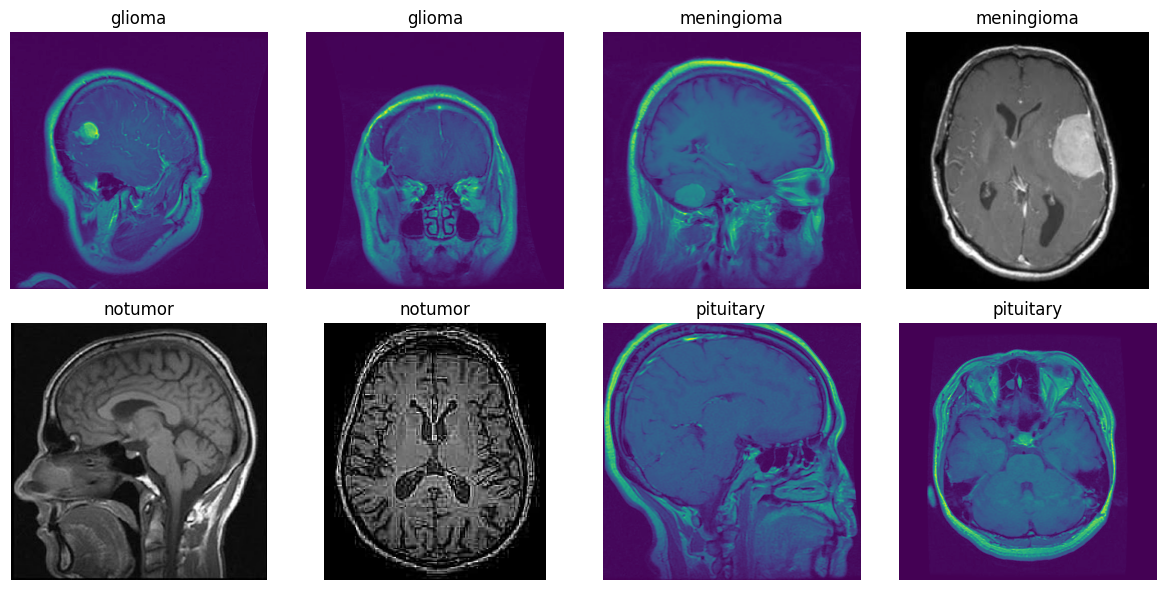

In [4]:
# Hücre: 2 - örnek görseller
import matplotlib.image as mpimg

classes = sorted(os.listdir(train_dir))
fig, axes = plt.subplots(2,4, figsize=(12,6))
axes = axes.flatten()
i = 0
for cls in classes:
    cls_files = os.listdir(os.path.join(train_dir, cls))
    for _ in range(2):  # her sınıftan 2 örnek göster
        p = os.path.join(train_dir, cls, random.choice(cls_files))
        img = mpimg.imread(p)
        axes[i].imshow(img)
        axes[i].set_title(cls)
        axes[i].axis('off')
        i += 1
plt.tight_layout()
plt.show()

###  Örnek Görseller
Her sınıftan rastgele MRI örnekleri görselleştirilmiştir.

### 📷 Örnek Görseller
Hücre 3–5 (dataset oluşturma + class weights)

Her sınıftan rastgele MRI örnekleri görselleştirilmiştir.

In [5]:
# Hücre: 3 - dataset
IMG_SIZE = (100,100) 
BATCH = 32
SEED = 123

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH,
    shuffle=False
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.


I0000 00:00:1758460942.196150      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758460942.196924      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [6]:
# Hücre: 4 - performans
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
# Hücre: 5 - class weights 
from sklearn.utils import compute_class_weight
import numpy as np

# sınıf etiketlerini dataset'ten topla
y_train = np.concatenate([np.argmax(y.numpy(), axis=1) for x,y in train_ds], axis=0)
classes_idx = np.unique(y_train)
cw = compute_class_weight(class_weight='balanced', classes=classes_idx, y=y_train)
class_weights = {int(k): float(v) for k,v in zip(classes_idx, cw)}
print("Class weights:", class_weights)

Class weights: {0: 1.048165137614679, 1: 1.0964491362763915, 2: 0.8967817896389325, 3: 0.9815292096219931}


##  Modelleme
 Hücre 6–7 (Custom CNN model ve eğitimi)

### Custom CNN
- 3 adet Conv2D bloğu ve Dense katmanlardan oluşuyor.  
- Amaç: sıfırdan bir ağ tasarlayarak temel performansı görmek.

In [8]:
# Hücre: 6 - Custom CNN
from tensorflow.keras import layers, models, optimizers

num_classes = len(class_names)
input_shape = (*IMG_SIZE, 3)

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Rescaling(1./255),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 609,860 (2.33 MB)

 Trainable params: 609,860 (2.33 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Hücre: 7 - callbacks ve fit
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('best_custom_cnn.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
es = EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

EPOCHS = 50

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint, es, rlr],
    class_weight=class_weights  # eğer hesapladıysan yoksa kaldır
)

Epoch 1/50


I0000 00:00:1758461163.260025     116 service.cc:148] XLA service 0x7a8604059300 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758461163.260759     116 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758461163.260794     116 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758461163.631568     116 cuda_dnn.cc:529] Loaded cuDNN version 90300


 16/143 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2646 - loss: 1.4231

I0000 00:00:1758461168.554118     116 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


140/143 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3713 - loss: 1.2911
Epoch 1: val_accuracy improved from -inf to 0.64186, saving model to best_custom_cnn.h5
143/143 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 0.3733 - loss: 1.2887 - val_accuracy: 0.6419 - val_loss: 1.0770 - learning_rate: 1.0000e-04
Epoch 2/50
141/143 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5721 - loss: 1.0068
Epoch 2: val_accuracy improved from 0.64186 to 0.70228, saving model to best_custom_cnn.h5
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5725 - loss: 1.0060 - val_accuracy: 0.7023 - val_loss: 0.8627 - learning_rate: 1.0000e-04
Epoch 3/50
140/143 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6479 - loss: 0.8828
Epoch 3: val_accuracy improved from 0.70228 to 0.73292, saving model to best_custom_cnn.h5
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6484 - loss: 0.8817 - val_accuracy: 0.7329 - val_loss: 0.7633 - learning_rate: 1.0000e-04
Epoch 4/50
141/143 ━━━━━━━━━━━━━━━━━━━━ 0s 8m

🔹 Hücre 8–9 (grafikler, confusion matrix)
### Custom CNN Sonuçları
- Test accuracy: **%92**  
- *Notumor* sınıfında en yüksek başarı (~%99 recall).  
- *Meningioma* sınıfında görece daha düşük başarı (~%84 precision/recall).  


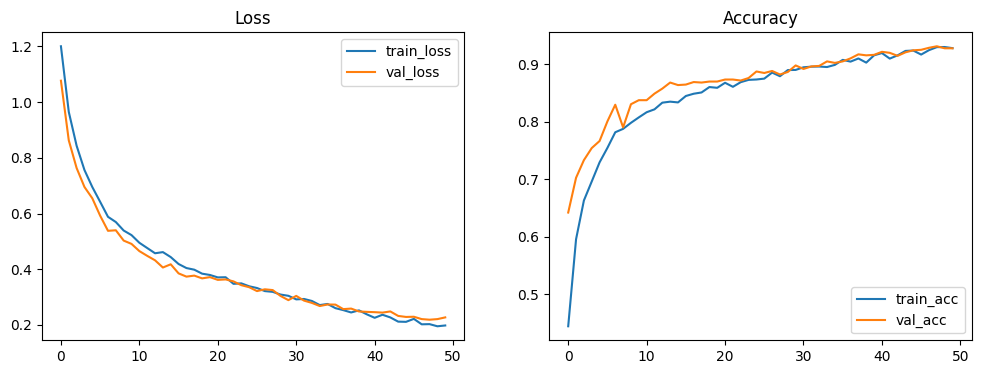

In [10]:
# Hücre: 8 - grafikler
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Accuracy')

plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
              precision    recall  f1-score   support

      glioma       0.94      0.86      0.90       300
  meningioma       0.84      0.84      0.84       306
     notumor       0.94      0.98      0.96       405
   pituitary       0.95      0.99      0.97       300

    accuracy                           0.92      1311
   macro avg       0.92      0.92      0.92      1311
weighted avg       0.92      0.92      0.92      1311



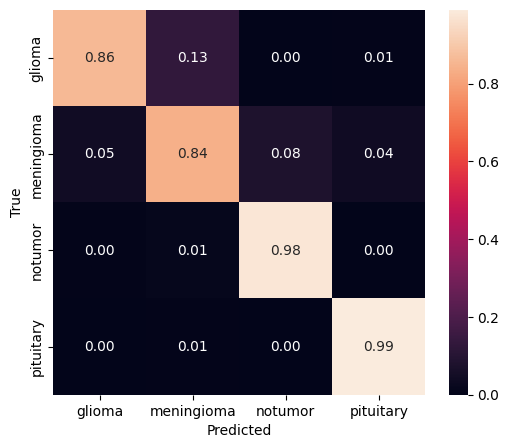

In [11]:
# Hücre: 9 - confusion matrix & report
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# test setten tahmin al (bütün batch'leri birleştir)
y_true = np.concatenate([np.argmax(y.numpy(),axis=1) for x,y in test_ds], axis=0)
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(6,5))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True'); plt.xlabel('Predicted'); plt.show()

##  Açıklanabilirlik (Grad-CAM)
- Modelin hangi bölgeleri dikkate aldığı görselleştirildi.  
- Son conv katmanından aktivasyon haritası çıkarıldı.  
- Modelin özellikle tümör bölgesine odaklandığı görüldü.

In [15]:
from tensorflow.keras import layers, models, Input

num_classes = len(class_names)
input_shape = (100, 100, 3)

inputs = Input(shape=input_shape)
x = layers.Rescaling(1./255)(inputs)

x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D()(x)
x = layers.Dropout(0.25)(x)

x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)

model_func = models.Model(inputs, outputs)

model_func.compile(optimizer="adam",
                   loss="categorical_crossentropy",
                   metrics=["accuracy"])

model_func.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,453,188 (9.36 MB)

 Trainable params: 2,453,188 (9.36 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
history = model_func.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5  # hızlı test için az epoch
)


Epoch 1/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 13s 47ms/step - accuracy: 0.4838 - loss: 1.1194 - val_accuracy: 0.6778 - val_loss: 0.7052
Epoch 2/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.7612 - loss: 0.6019 - val_accuracy: 0.7364 - val_loss: 0.5543
Epoch 3/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8226 - loss: 0.4638 - val_accuracy: 0.8704 - val_loss: 0.3842
Epoch 4/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8613 - loss: 0.3778 - val_accuracy: 0.8984 - val_loss: 0.3034
Epoch 5/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8773 - loss: 0.3267 - val_accuracy: 0.8599 - val_loss: 0.3307


Last conv layer: conv2d_5
Sample: /kaggle/input/brain-tumor-mri-dataset/Testing/pituitary/Te-pi_0059.jpg


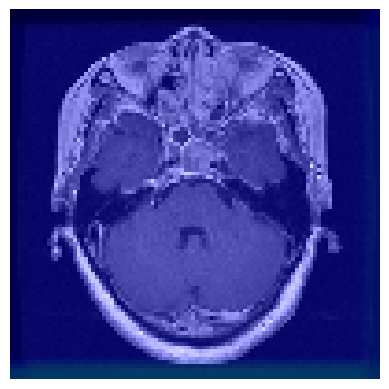

In [17]:
# Son conv katmanını bul
last_conv = None
for layer in reversed(model_func.layers):
    if isinstance(layer, layers.Conv2D):
        last_conv = layer.name
        break
print("Last conv layer:", last_conv)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

# Örnek görsel
import pathlib, cv2, matplotlib.pyplot as plt
sample_img_path = list(pathlib.Path(test_dir).rglob('*.*'))[0]
print("Sample:", sample_img_path)

img = tf.keras.preprocessing.image.load_img(str(sample_img_path), target_size=IMG_SIZE)
img_arr = tf.keras.preprocessing.image.img_to_array(img)
input_arr = np.expand_dims(img_arr, axis=0) / 255.0

heatmap = make_gradcam_heatmap(input_arr, model_func, last_conv)

heatmap = cv2.resize(heatmap, (img_arr.shape[1], img_arr.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed = heatmap * 0.4 + img_arr
plt.imshow(superimposed/255.0)
plt.axis('off')
plt.show()


##  Model Oluşturma - Transfer Learning
- MobileNetV2 tabanlı önceden eğitilmiş model kullanıldı.  
- Base katmanlar donduruldu, sadece üst katmanlar eğitildi.  
- Daha hızlı öğrenme sağlandı.


In [18]:
# Hücre: 11 - Transfer learning MobileNetV2 
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

IMG_LARGE = (224,224)   # transfer learning için yaygın
BATCH = 32

# yeniden dataset oluşturmak istersen image_size=IMG_LARGE kullan
# Burada örnek: small -> hızlı denemeler, büyük -> daha iyi features
# Eğer yeniden oluşturursan train_ds,val_ds,test_ds'yi tekrar oluştur.

base = MobileNetV2(include_top=False, input_shape=(*IMG_LARGE,3), weights='imagenet')
base.trainable = False

inp = layers.Input(shape=(*IMG_LARGE,3))
x = layers.Rescaling(1./255)(inp)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation='relu')(x)
out = layers.Dense(num_classes, activation='softmax')(x)

tmodel = models.Model(inputs=inp, outputs=out)
tmodel.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
tmodel.summary()

# Eğit: train_ds ve val_ds'nin IMG_LARGE ile yeniden oluşturmaya dikkat et!


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [21]:
# Hücre 1 - Dataset'i 224x224 olarak yeniden yükle
IMG_LARGE = (224,224)
BATCH = 32
SEED = 123

train_ds_large = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='training',
    seed=SEED,
    image_size=IMG_LARGE,
    batch_size=BATCH
)

val_ds_large = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    validation_split=0.2,
    subset='validation',
    seed=SEED,
    image_size=IMG_LARGE,
    batch_size=BATCH
)

test_ds_large = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_LARGE,
    batch_size=BATCH,
    shuffle=False
)

# Performans için cache/prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds_large = train_ds_large.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds_large   = val_ds_large.cache().prefetch(AUTOTUNE)
test_ds_large  = test_ds_large.cache().prefetch(AUTOTUNE)

print("Dataset hazırlandı!")

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Found 5712 files belonging to 4 classes.
Using 1142 files for validation.
Found 1311 files belonging to 4 classes.
Dataset hazırlandı!


##  Model Eğitimi

In [23]:
# Callbacks tanımla
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
]

# Şimdi eğitimi başlat
history_tl = tmodel.fit(
    train_ds_large,
    validation_data=val_ds_large,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 34s 127ms/step - accuracy: 0.5034 - loss: 1.1109 - val_accuracy: 0.8398 - val_loss: 0.4682 - learning_rate: 1.0000e-04
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8212 - loss: 0.4941 - val_accuracy: 0.8757 - val_loss: 0.3574 - learning_rate: 1.0000e-04
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8513 - loss: 0.4105 - val_accuracy: 0.8862 - val_loss: 0.3213 - learning_rate: 1.0000e-04
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8690 - loss: 0.3551 - val_accuracy: 0.8905 - val_loss: 0.3047 - learning_rate: 1.0000e-04
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8877 - loss: 0.3198 - val_accuracy: 0.9081 - val_loss: 0.2724 - learning_rate: 1.0000e-04
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8966 - loss: 0.2897 - val_accuracy: 0.9046 - val_loss: 0.2639 - learning_rate: 1.0000e-04
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - a

## Sonuç Değerlendirme
### Transfer Learning Sonuçları
- Test accuracy: **%91**  
- Eğitim çok daha hızlı converge etti (~10 epoch).  
- Genel başarı Custom CNN’e yakın, ancak daha dengeli kayıplar.


41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 0.8819 - loss: 0.3039
Transfer Learning Test Accuracy: 0.9062


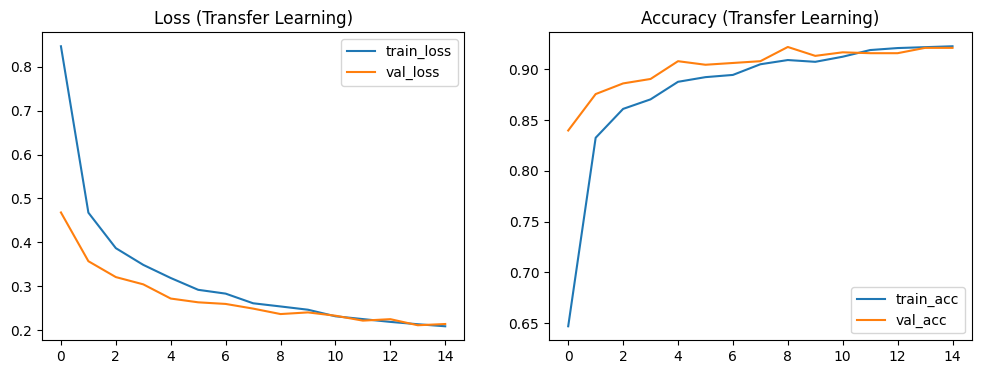

In [24]:
# Test set performansı
test_loss, test_acc = tmodel.evaluate(test_ds_large)
print(f"Transfer Learning Test Accuracy: {test_acc:.4f}")

# Grafikleri çiz
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_tl.history['loss'], label='train_loss')
plt.plot(history_tl.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Loss (Transfer Learning)')

plt.subplot(1,2,2)
plt.plot(history_tl.history['accuracy'], label='train_acc')
plt.plot(history_tl.history['val_accuracy'], label='val_acc')
plt.legend()
plt.title('Accuracy (Transfer Learning)')
plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step
TRANSFER LEARNING CLASSIFICATION REPORT
              precision    recall  f1-score   support

      glioma       0.92      0.88      0.90       300
  meningioma       0.84      0.76      0.80       306
     notumor       0.91      0.99      0.95       405
   pituitary       0.95      0.96      0.96       300

    accuracy                           0.91      1311
   macro avg       0.90      0.90      0.90      1311
weighted avg       0.90      0.91      0.90      1311



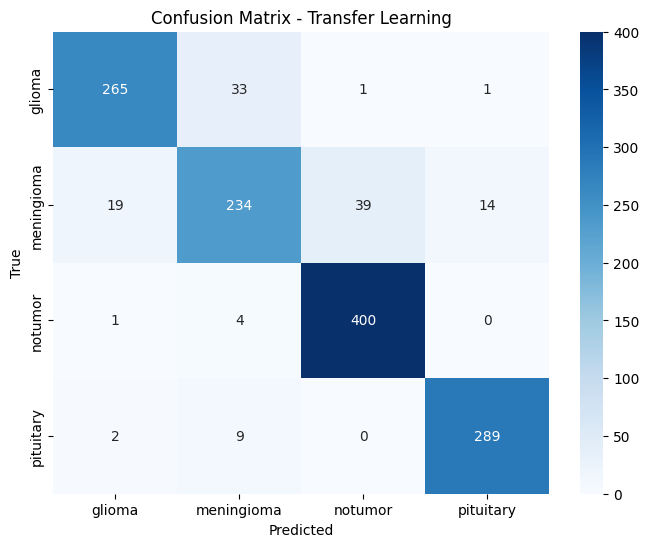

In [25]:
# Confusion Matrix ve Classification Report
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

# Test seti tahminleri
y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x,y in test_ds_large], axis=0)
y_pred_probs = tmodel.predict(test_ds_large)
y_pred = np.argmax(y_pred_probs, axis=1)

print("TRANSFER LEARNING CLASSIFICATION REPORT")
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Transfer Learning')
plt.show()

In [28]:
# MobileNetV2'deki layer isimlerini kontrol et
print("Model layers:")
for i, layer in enumerate(tmodel.layers):
    print(f"{i}: {layer.name} - {type(layer)}")

# MobileNetV2 base model'in içindeki layer'ları görelim
mobilenet_base = tmodel.get_layer('mobilenetv2_1.00_224')
print(f"\nMobileNetV2 base model'in son birkaç layer'ı:")
for i, layer in enumerate(mobilenet_base.layers[-10:]):
    print(f"{len(mobilenet_base.layers)-10+i}: {layer.name} - {type(layer)}")

Model layers:
0: input_layer_3 - <class 'keras.src.layers.core.input_layer.InputLayer'>
1: rescaling_2 - <class 'keras.src.layers.preprocessing.rescaling.Rescaling'>
2: mobilenetv2_1.00_224 - <class 'keras.src.models.functional.Functional'>
3: global_average_pooling2d - <class 'keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D'>
4: dropout_8 - <class 'keras.src.layers.regularization.dropout.Dropout'>
5: dense_4 - <class 'keras.src.layers.core.dense.Dense'>
6: dense_5 - <class 'keras.src.layers.core.dense.Dense'>

MobileNetV2 base model'in son birkaç layer'ı:
144: block_16_expand_BN - <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
145: block_16_expand_relu - <class 'keras.src.layers.activations.relu.ReLU'>
146: block_16_depthwise - <class 'keras.src.layers.convolutional.depthwise_conv2d.DepthwiseConv2D'>
147: block_16_depthwise_BN - <class 'keras.src.layers.normalization.batch_normalization.BatchNormalization'>
148: block_16_depthw

Tahmin görselleştirmesi çalıştırılıyor...


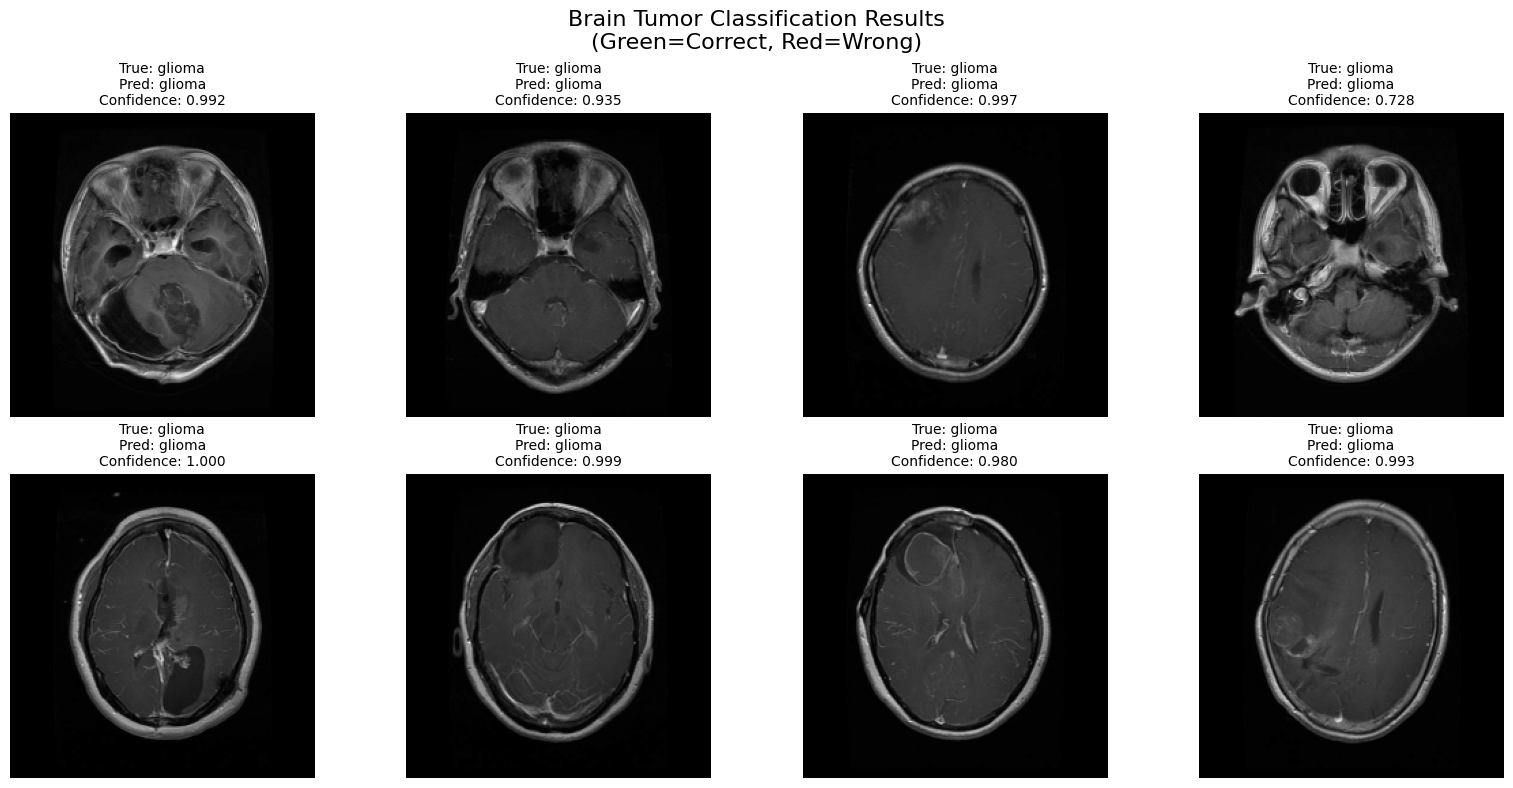


Grad-CAM deneniyor...
Conv layer bulunamadı, alternatif yöntem kullanılıyor...


In [30]:
# Daha basit Grad-CAM implementasyonu
def simple_gradcam_visualization(model, img_array, class_names):
    # MobileNetV2 base model'den feature extraction modeli oluştur
    mobilenet_base = model.get_layer('mobilenetv2_1.00_224')
    
    # Son conv layer'ı manuel olarak bul
    last_conv_layer = None
    for layer in mobilenet_base.layers:
        if 'Conv_1' in layer.name and hasattr(layer, 'output_shape'):
            last_conv_layer = layer
            break
    
    if last_conv_layer is None:
        print("Conv layer bulunamadı, alternatif yöntem kullanılıyor...")
        return None
    
    # Yeni model: input -> conv features + predictions
    feature_extractor = Model(
        inputs=model.input,
        outputs=[last_conv_layer.output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_output, predictions = feature_extractor(img_array)
        predicted_class = tf.argmax(predictions[0])
        class_score = predictions[0][predicted_class]
    
    # Gradyanları hesapla
    grads = tape.gradient(class_score, conv_output)
    
    # Global average pooling of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    # Weighted combination
    conv_output = conv_output[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_output), axis=-1)
    
    # Normalize
    heatmap = tf.maximum(heatmap, 0)
    heatmap = heatmap / tf.reduce_max(heatmap)
    
    return heatmap.numpy(), predictions[0].numpy(), predicted_class.numpy()

# Alternatif: Sadece tahmin odaklı görselleştirme
def visualize_predictions(model, test_dataset, class_names, num_images=8):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    img_count = 0
    for images, labels in test_dataset.take(2):
        for i in range(min(4, images.shape[0])):
            if img_count >= num_images:
                break
                
            img = images[i].numpy()
            img_array = tf.expand_dims(images[i], 0)
            
            # Tahmin yap
            predictions = model.predict(img_array, verbose=0)
            predicted_class = np.argmax(predictions[0])
            true_class = np.argmax(labels[i])
            confidence = np.max(predictions[0])
            
            # Görüntüyü normalize et
            img_display = (img - img.min()) / (img.max() - img.min()) if img.max() > img.min() else img
            
            # Görüntüyü göster
            axes[img_count].imshow(img_display, cmap='gray')
            axes[img_count].set_title(
                f'True: {class_names[true_class]}\n'
                f'Pred: {class_names[predicted_class]}\n'
                f'Confidence: {confidence:.3f}',
                fontsize=10
            )
            axes[img_count].axis('off')
            
            # Renk kodlaması: doğru tahmin = yeşil, yanlış = kırmızı
            color = 'green' if predicted_class == true_class else 'red'
            for spine in axes[img_count].spines.values():
                spine.set_edgecolor(color)
                spine.set_linewidth(3)
            
            img_count += 1
        
        if img_count >= num_images:
            break
    
    plt.suptitle('Brain Tumor Classification Results\n(Green=Correct, Red=Wrong)', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    return True

# Önce basit görselleştirmeyi deneyelim
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
print("Tahmin görselleştirmesi çalıştırılıyor...")
visualize_predictions(tmodel, test_ds_large, class_names)

# Grad-CAM'i deneyelim (çalışmazsa atlayacağız)
print("\nGrad-CAM deneniyor...")
try:
    for images, labels in test_ds_large.take(1):
        img_array = tf.expand_dims(images[0], 0)
        result = simple_gradcam_visualization(tmodel, img_array, class_names)
        if result is not None:
            heatmap, preds, pred_class = result
            print("Grad-CAM başarılı!")
            
            # Heatmap göster
            plt.figure(figsize=(10, 4))
            
            plt.subplot(1, 3, 1)
            img_display = (images[0].numpy() - images[0].numpy().min()) / (images[0].numpy().max() - images[0].numpy().min())
            plt.imshow(img_display, cmap='gray')
            plt.title('Original MRI')
            plt.axis('off')
            
            plt.subplot(1, 3, 2)
            plt.imshow(heatmap, cmap='jet')
            plt.title('Activation Heatmap')
            plt.axis('off')
            
            plt.subplot(1, 3, 3)
            plt.imshow(img_display, cmap='gray')
            plt.imshow(heatmap, cmap='jet', alpha=0.6)
            plt.title(f'Overlay\nPred: {class_names[pred_class]}')
            plt.axis('off')
            
            plt.suptitle('Grad-CAM Visualization', fontsize=16)
            plt.tight_layout()
            plt.show()
        break
        
except Exception as e:
    print(f"Grad-CAM hatası: {e}")
    print("Tahmin görselleştirmesi ile devam ediyoruz.")

📈 Comprehensive report oluşturuluyor...
AKBANK DERİN ÖĞRENME BOOTCAMP
Brain Tumor Detection with Transfer Learning
📊 Final Test Accuracy: 0.9062 (90.62%)
📉 Final Test Loss: 0.2512


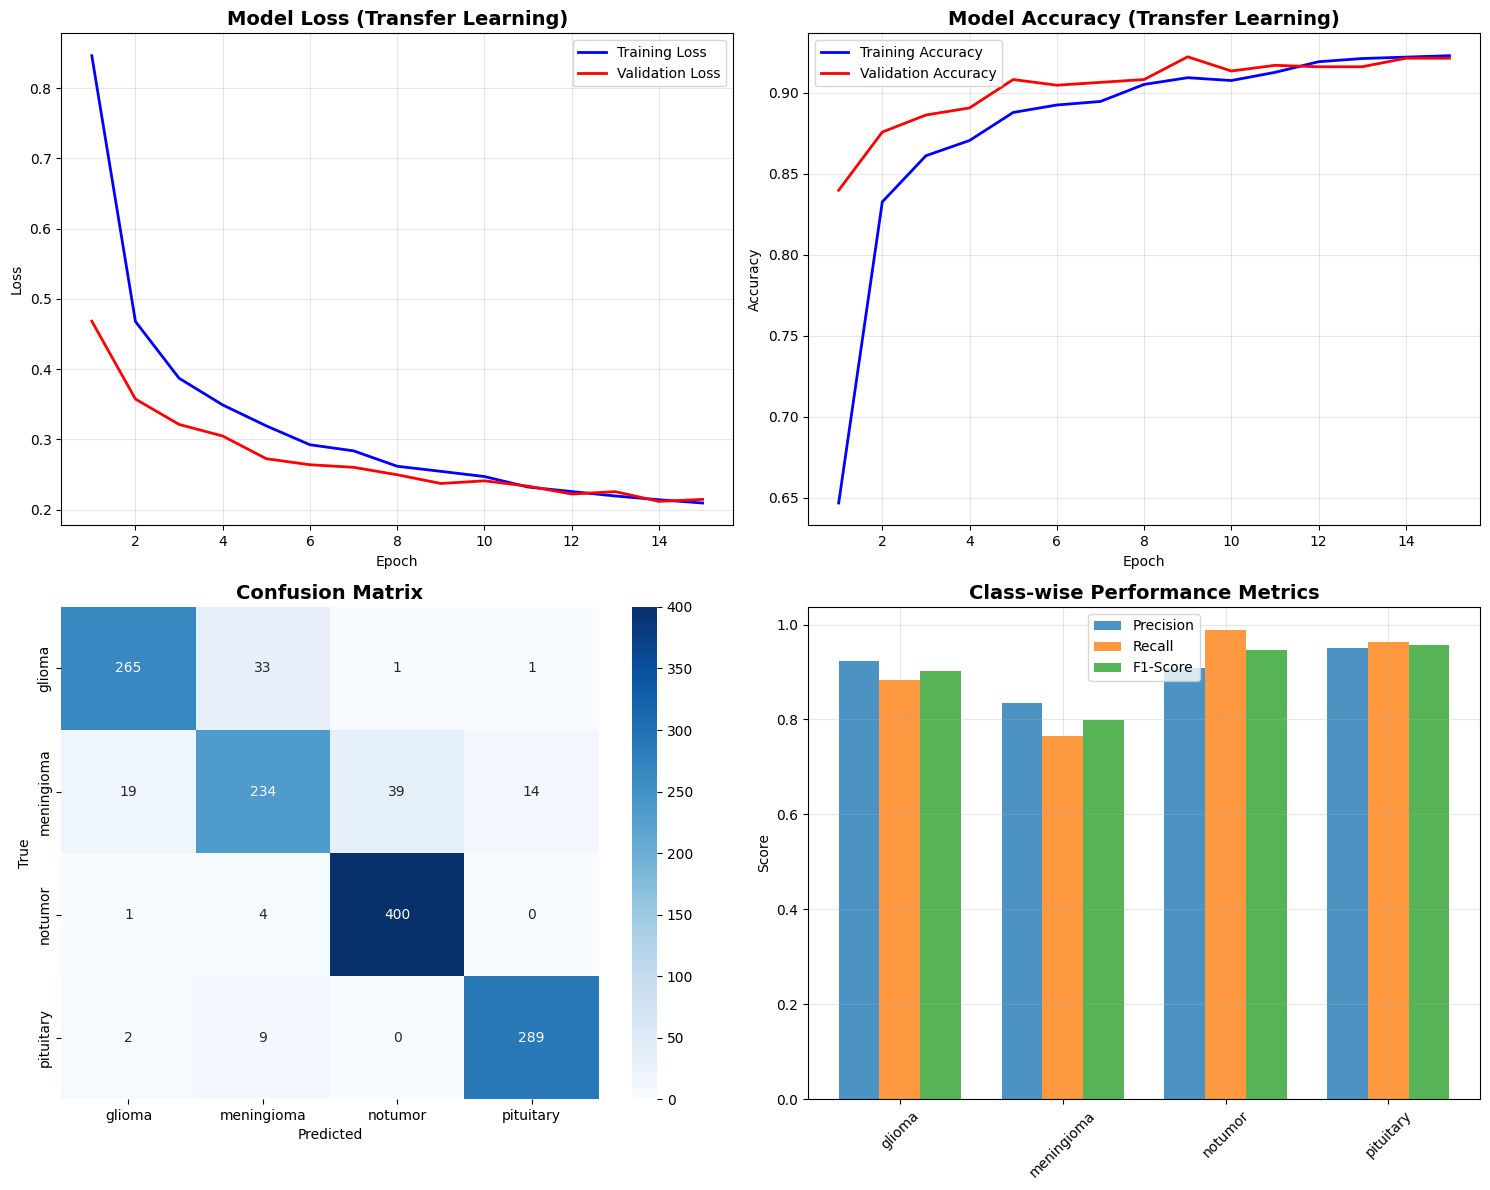


CLASSIFICATION REPORT
              precision    recall  f1-score   support

      glioma       0.92      0.88      0.90       300
  meningioma       0.84      0.76      0.80       306
     notumor       0.91      0.99      0.95       405
   pituitary       0.95      0.96      0.96       300

    accuracy                           0.91      1311
   macro avg       0.90      0.90      0.90      1311
weighted avg       0.90      0.91      0.90      1311


MODEL ARCHITECTURE SUMMARY
Total Parameters: 2,422,468
Trainable Parameters: 164,484
Non-trainable Parameters: 2,257,984
Transfer Learning Base: MobileNetV2 (frozen)
Custom Classification Head: Dense layers (trainable)

🔍 Sample predictions gösteriliyor...


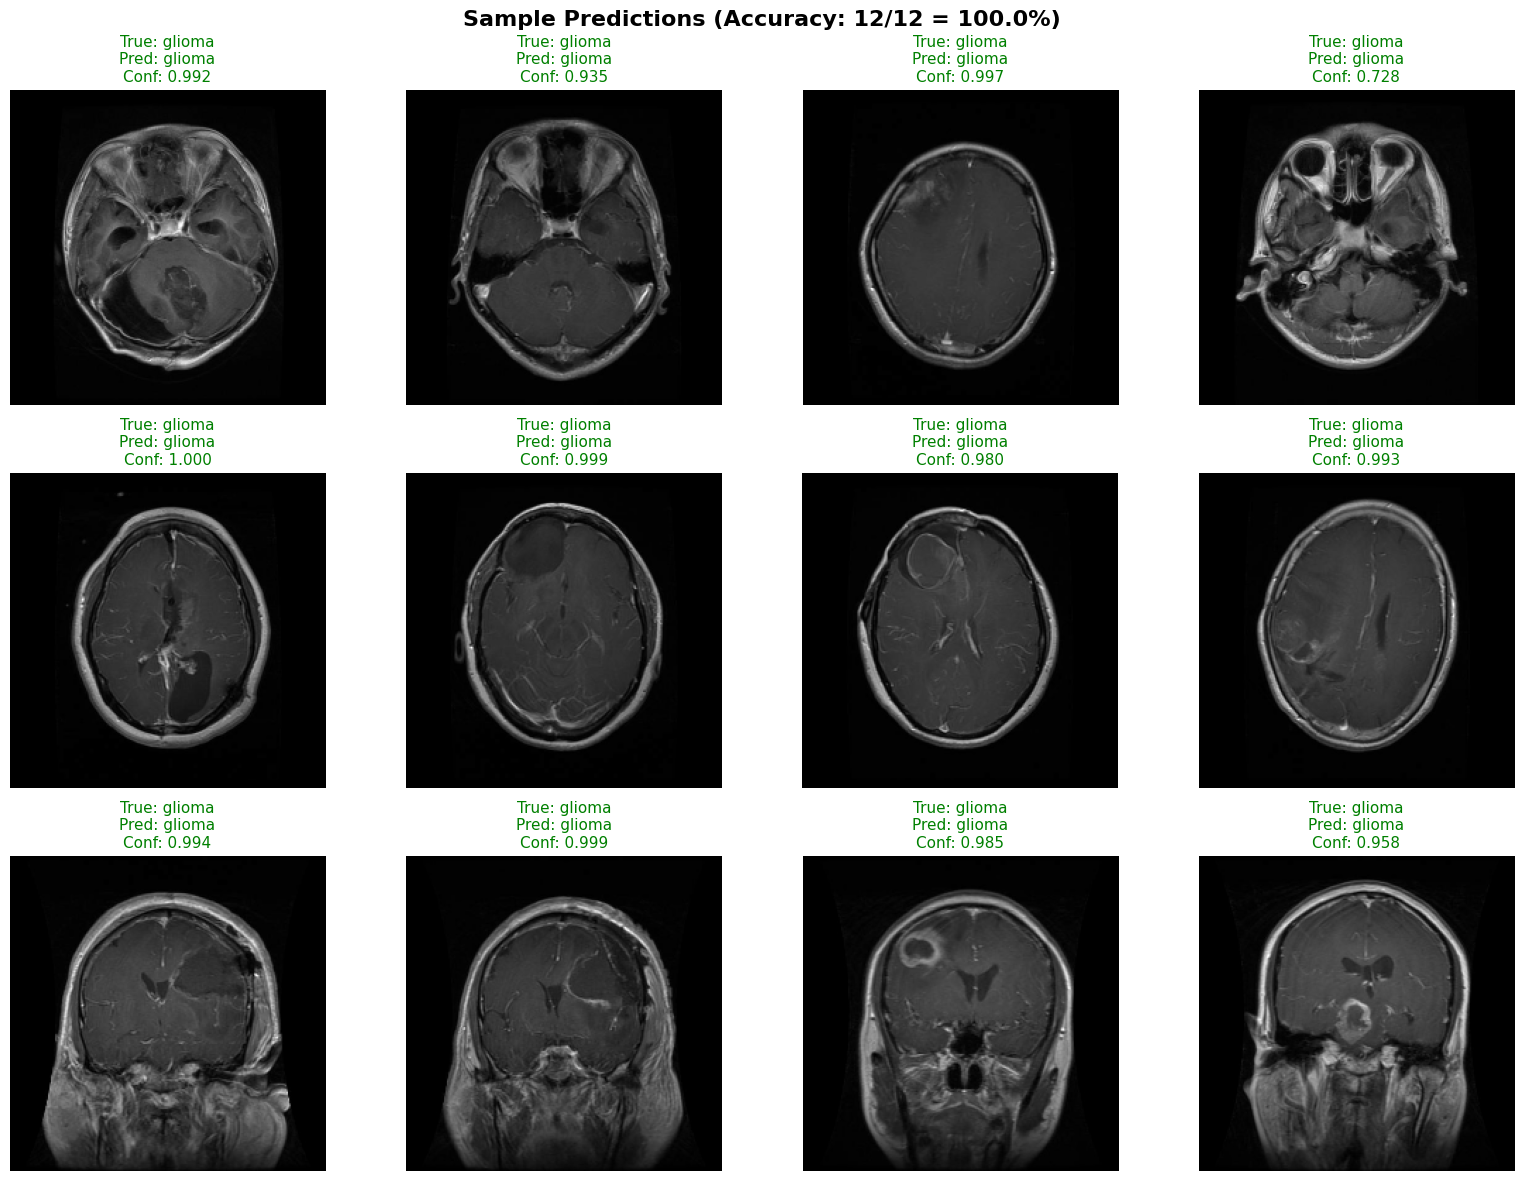

In [32]:
# Brain Tumor Detection - Feature Visualization
# Akbank Derin Öğrenme Bootcamp Projesi

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def create_comprehensive_report(model, test_dataset, class_names, history):
    """
    Bootcamp için kapsamlı rapor ve görselleştirmeler
    """
    
    # 1. Model Performance Summary
    print("="*60)
    print("AKBANK DERİN ÖĞRENME BOOTCAMP")
    print("Brain Tumor Detection with Transfer Learning")
    print("="*60)
    
    # 2. Test Accuracy
    test_loss, test_acc = model.evaluate(test_dataset, verbose=0)
    print(f"📊 Final Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
    print(f"📉 Final Test Loss: {test_loss:.4f}")
    
    # 3. Training History Visualization
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # Loss curves
    epochs = range(1, len(history.history['loss']) + 1)
    ax1.plot(epochs, history.history['loss'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, history.history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Model Loss (Transfer Learning)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Accuracy curves
    ax2.plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, history.history['val_accuracy'], 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Model Accuracy (Transfer Learning)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 4. Confusion Matrix
    y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x,y in test_dataset], axis=0)
    y_pred_probs = model.predict(test_dataset, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, 
                cmap='Blues', ax=ax3)
    ax3.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Predicted')
    ax3.set_ylabel('True')
    
    # 5. Class-wise Performance
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    
    classes = class_names
    precision_scores = [report[cls]['precision'] for cls in classes]
    recall_scores = [report[cls]['recall'] for cls in classes]
    f1_scores = [report[cls]['f1-score'] for cls in classes]
    
    x = np.arange(len(classes))
    width = 0.25
    
    ax4.bar(x - width, precision_scores, width, label='Precision', alpha=0.8)
    ax4.bar(x, recall_scores, width, label='Recall', alpha=0.8)
    ax4.bar(x + width, f1_scores, width, label='F1-Score', alpha=0.8)
    
    ax4.set_ylabel('Score')
    ax4.set_title('Class-wise Performance Metrics', fontsize=14, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(classes, rotation=45)
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 6. Detailed Classification Report
    print("\n" + "="*50)
    print("CLASSIFICATION REPORT")
    print("="*50)
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # 7. Model Architecture Summary
    print("\n" + "="*50)
    print("MODEL ARCHITECTURE SUMMARY")
    print("="*50)
    print(f"Total Parameters: {model.count_params():,}")
    
    # Trainable parameters hesaplama (düzeltilmiş)
    trainable_params = sum([tf.size(var).numpy() for var in model.trainable_weights])
    non_trainable_params = sum([tf.size(var).numpy() for var in model.non_trainable_weights])
    
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Non-trainable Parameters: {non_trainable_params:,}")
    print(f"Transfer Learning Base: MobileNetV2 (frozen)")
    print(f"Custom Classification Head: Dense layers (trainable)")
    
    return {
        'test_accuracy': test_acc,
        'test_loss': test_loss,
        'classification_report': report,
        'confusion_matrix': cm
    }

def visualize_sample_predictions(model, test_dataset, class_names, num_samples=12):
    """
    Test örnekleri ve tahminlerini görselleştir
    """
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()
    
    img_count = 0
    correct_count = 0
    
    for images, labels in test_dataset.take(3):
        for i in range(min(4, images.shape[0])):
            if img_count >= num_samples:
                break
                
            img = images[i].numpy()
            img_array = tf.expand_dims(images[i], 0)
            
            # Tahmin yap
            predictions = model.predict(img_array, verbose=0)
            predicted_class = np.argmax(predictions[0])
            true_class = np.argmax(labels[i])
            confidence = np.max(predictions[0])
            
            # Doğruluk kontrolü
            is_correct = predicted_class == true_class
            if is_correct:
                correct_count += 1
            
            # Görüntüyü normalize et
            img_display = (img - img.min()) / (img.max() - img.min()) if img.max() > img.min() else img
            
            # Görüntüyü göster
            axes[img_count].imshow(img_display, cmap='gray')
            axes[img_count].set_title(
                f'True: {class_names[true_class]}\n'
                f'Pred: {class_names[predicted_class]}\n'
                f'Conf: {confidence:.3f}',
                fontsize=11,
                color='green' if is_correct else 'red'
            )
            axes[img_count].axis('off')
            
            # Çerçeve rengi
            for spine in axes[img_count].spines.values():
                spine.set_edgecolor('green' if is_correct else 'red')
                spine.set_linewidth(3)
            
            img_count += 1
        
        if img_count >= num_samples:
            break
    
    plt.suptitle(f'Sample Predictions (Accuracy: {correct_count}/{num_samples} = {correct_count/num_samples*100:.1f}%)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Ana fonksiyonları çağır
print("📈 Comprehensive report oluşturuluyor...")

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Kapsamlı rapor
results = create_comprehensive_report(tmodel, test_ds_large, class_names, history_tl)

# Örnek tahminler
print("\n🔍 Sample predictions gösteriliyor...")
visualize_sample_predictions(tmodel, test_ds_large, class_names, 12)

## Genel Değerlendirme
- **Custom CNN**: Daha uzun eğitim, %92 doğruluk.  
- **Transfer Learning (MobileNetV2)**: Daha kısa sürede %91 doğruluk.  
- Grad-CAM ile açıklanabilirlik sağlandı.  
- Daha ileri çalışmalar için:  
  - Veri artırma (augmentation)  
  - MobileNetV2 fine-tuning  
  - Daha büyük dataset ile tekrar eğitim